In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import string
import random

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mpl.rcParams['lines.linewidth'] = 2

### Functions for generating the data

In [10]:
def generate_data(size, scheme, seed, a=5.0, b1=7.0, b2=14.0, c=0.0):
    """
    Generates data that serves as input to the function.
    Args:
        size: (int) the total number of data points
        scheme: (str) the nature of the generated data
        seed: (int) the number used to initialize random number generation
        a: (float) constant parameter
        b1: (float) time-varying parameter
        b2: (float) time-varying parameter

    Returns:
        (torch.tensor) values for a
        (torch.tensor) values for b
    """

    A = [a for i in range(size)]
    B = [b1 for i in range(size)]
    C = [c for i in range(size)]
    if scheme == "step":
        B = [b1 if i < size/2 else b2 for i in range(size)]
    elif scheme == "random":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
    elif scheme == "alternate":
        B = [b1 if i % 2 == 0 else b2 for i in range(size)]
    elif scheme == "shift":
        C = [c if i < size / 2 else 5 for i in range(size)]
    elif scheme == "random_shift":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
        C = [c if i < size / 2 else 5 for i in range(size)]

    return torch.tensor(np.array(A)), torch.tensor(np.array(B)), torch.tensor(np.array(C))




In [11]:
def cost(a, b, c, x):
    """
    the cost function
    Args:
        a, b, c: (torch.tensor) the parameters
        x: (torch.Parameter) the variable
    """

    return torch.log(a) + torch.log(torch.exp(-b * (x-c)) + torch.exp(b * (x-c)))

### Optimizers

In [12]:
def optimize_cost(n_iters, lr, x0, optimizer_name, a_vec, b_vec, c_vec,
                  decay=False, normalize=False):
    """
    optimizes the cost function
    """

    loss_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    x_values = [x.item()]
    optimizer = optim.Adagrad([x], lr=lr)
    if optimizer_name == "Adam":
        optimizer = optim.Adam([x], lr=lr)
    elif optimizer_name == "GD":
        optimizer = optim.SGD([x], lr=lr)
    for i in tqdm(range(n_iters)):
        if optimizer_name == "Adam":
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if decay:
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if normalize:
            optimizer.param_groups[0]['lr']=lr / (b_vec[i] ** 2)

        optimizer.zero_grad()
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        #print(loss)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        x_values.append(optimizer.param_groups[0]['params'][0].item())

    ## the parameters and loss after the final update
    #loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    #loss_values.append(loss.item())
    #x_values.append(optimizer.param_groups[0]['params'][0].item())

    return np.array(loss_values) #, np.array(x_values)

def optimize_cost_ht(gamma, n_iters,x0, a_vec, b_vec, c_vec):
    """
    optimizers the cost using higher order tuner
    """
    
    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float)
    z = torch.tensor(x0, dtype=torch.float)

    beta = 1 / gamma
    for i in tqdm(range(n_iters)):
        N_t = b_vec[i] ** 2
        mu=1
        alpha = mu / N_t
        eta = gamma / N_t
        x = beta * z + (1 - beta) * y
        x.requires_grad = True
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad
            z = z - eta * x.grad

        x_values.append(x.item())
        x.grad = None

    #loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    #loss_values.append(loss.item())
    #x_values.append(x.item())

    return np.array(loss_values)#, np.array(x_values)

def optimize_cost_NAGD(n_iters, x0, a_vec, b_vec, c_vec, mu=1, gamma=1,
                       normalize=False):
    """
    optimizes the function using Nesterov's Accelerated Gradient Descent
    """

    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float)
    ## this corresponds to tilde z
    z = torch.tensor(x0, dtype=torch.float) * 2

    for i in tqdm(range(n_iters)):
        N_t = 1
        gamma = i / 2
        if normalize:
            N_t = b_vec[i] ** 2
            eta = gamma / N_t
        else:
            # assuming we are provided with TN-rate
            eta = gamma * mu
        alpha = mu / N_t

        beta = 2 / (i + 1)
        beta_next = 2 / (i + 2)
        x = z + (1 - beta) * y
        x.requires_grad = True
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad.data
            z = beta_next / beta * z - beta_next * eta * x.grad.data

        x_values.append(x.item())
        x.grad = None

    return np.array(loss_values)#, np.array(x_values)


### Generate the data

In [13]:
N = 100
data_a_step, data_b_step, data_c_step = generate_data(N, "step", 101, b1=7.0, b2=21.0)


### Initialize values

In [17]:
start = 7

### Changing b from 7 to 21 halfway

In [18]:
adam_step_loss = np.zeros(N)
adagrad_step_loss = np.zeros(N)
ht_step_loss = np.zeros(N)
normalized_gd_step_loss = np.zeros(N)
normalized_nagd_step_loss = np.zeros(N)
gd_step_loss = np.zeros(N)
nagd_step_loss = np.zeros(N)


ht_step_loss = optimize_cost_ht(1.5, N, start, data_a_step, data_b_step,data_c_step) 
normalized_gd_step_loss = optimize_cost(N, 1, start, "GD", data_a_step,data_b_step, data_c_step, normalize=True) 
normalized_nagd_step_loss = optimize_cost_NAGD(N, start, data_a_step, data_b_step, data_c_step, normalize=True) 
gd_step_loss = optimize_cost(N, 1/49, start, "GD", data_a_step,data_b_step, data_c_step, normalize=False) 
nagd_step_loss = optimize_cost_NAGD(N, start, data_a_step, data_b_step,data_c_step, mu=1/49, normalize=False) 

100%|██████████| 100/100 [00:00<00:00, 10900.52it/s]


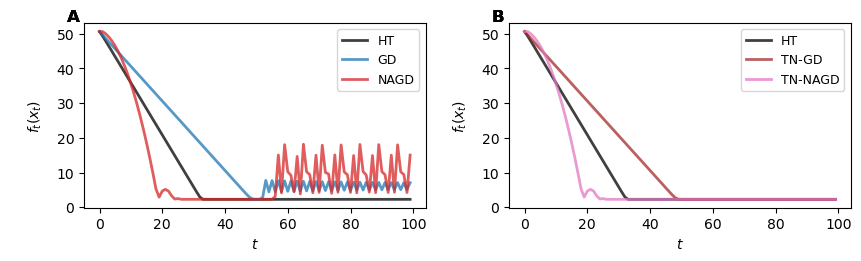

In [19]:
COLOR_DICT = {"GD": "tab:blue", "Adam": "tab:green",
             "Adagrad":"tab:orange", "NAGD":"tab:red",
             "TN-GD":"brown", "TN-NAGD":"tab:pink",
              "HT": "black"}

def draw_axes(axes, data_dict, list_keys, x_label, y_label,
             axes_label=None, set_legend=True, linewidth=0.5):

    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label,labelpad=9)
    #print(data_dict)
    for key in list_keys:
        y_data = data_dict[key]
        x_data = np.arange(0, len(y_data))
        #print(x_data)
        axes.plot(x_data, y_data, linewidth=2, alpha=0.75, color=COLOR_DICT[key],
                 label=key)
        if axes_label is not None:
            #axes.set_title(axes_label, loc="left", fontweight="bold")
            axes.text(-0.05, 1.01, axes_label, transform=axes.transAxes, fontsize=12, fontweight='bold')

    if set_legend:
        axes.legend(prop={'size': 9})

def make_figure(data_dict, panel_a_opt, panel_b_opt,
               location="fig_output", name="figure.pdf",
               x_label=r"$t$", y_label="\n$f_t(x_t)$"):
    """
    makes the figures

    Args:
        data_dict: (str) optimizer name -> (np.ndarray) results
        panel_a_opt:(List[str])
        panel_b_opt:(List[str])
  
    """

    fig = plt.figure(figsize=(8.5, 2.5), layout='constrained')
    #plt.subplots_adjust(left=.2)
    axes1 = fig.add_subplot(1, 2, 1)
    axes2 = fig.add_subplot(1, 2, 2)


    draw_axes(axes1, data_dict, panel_a_opt, x_label, y_label, "A")
    draw_axes(axes2, data_dict, panel_b_opt, x_label, y_label, "B")
    
    fig.savefig(name, pad_inches=0,bbox_inches='tight')

def make_plot(x, y_dict, x_label, y_label, title):

    fig = plt.figure(figsize=(8.5, 2.55), layout='constrained')
    axes = fig.add_subplot(1, 1, 1)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)

    for key in y_dict:
        axes.plot(x, y_dict[key], label=key)
        axes.legend(prop={'size': 7})
    

    fig.savefig(name, bbox_inches='tight', pad_inches=0)
    #plt.close()


results_step = {"TN-NAGD":normalized_nagd_step_loss, "TN-GD": normalized_gd_step_loss,
             "GD": gd_step_loss, "HT": ht_step_loss, "NAGD":nagd_step_loss,
             "Adam": adam_step_loss, "Adagrad":adagrad_step_loss}
panel_a = ["HT", "GD", "NAGD"]
panel_b = ["HT", "TN-GD", "TN-NAGD"]
panel_c = ["HT", "Adam", "Adagrad"]
make_figure(results_step, panel_a, panel_b, name='figure2.pdf')
